<a href="https://colab.research.google.com/github/luizgustandrade/Python-Projects/blob/main/Rapids_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jul 16 20:04:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 8.51 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 1.40s
 Downloaded cudf-cu12
 Downloaded rmm-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded cugraph-cu12
 Downloaded cuproj-cu12
 Downloaded dask
 Downloaded ucx-py-cu12
 Downloaded pylibcugraph-cu12
 Downloaded libkvikio-cu12
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuspatial-cu12
 Downloaded bokeh
 Downloaded pylibcudf-cu12
 Downloaded cuml-cu12
 Downloaded libraft-cu12
 Downloaded libcuspatial-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcudf-cu12
 Downloaded libcuvs

In [3]:
import cudf
cudf.__version__

'25.04.00'

In [4]:
import cuml
cuml.__version__

'25.04.00'

In [5]:
import cugraph
cugraph.__version__

'25.04.01'

In [6]:
import cuspatial
cuspatial.__version__

'25.04.00'

In [7]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

In [8]:
# prompt: # Define Parameters

n_samples = 100000
n_features = 25
n_clusters = 8
random_state = 0

In [9]:
device_data, device_labels = make_blobs(
    centers=n_clusters,
    n_features=n_features,
    n_samples=n_samples,
    random_state=random_state,
    cluster_std=0.1
)

In [10]:
#Copy CuPY arrays from GPU Memory to host Memory (Numpy Arrays)
# This is done to later compare CPU and GPU results.
host_data = device_data.get()
host_labels = device_labels.get()

In [21]:
kmeans_sk = skKMeans(
    init="k-means++",
    n_clusters=n_clusters, random_state=random_state, n_init='auto')
%timeit kmeans_sk.fit(host_data)

121 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
kmeans_cuml = cuKMeans(
    init="k-means||",
    n_clusters=n_clusters, random_state=random_state)

%timeit kmeans_cuml.fit(device_data)

15.2 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


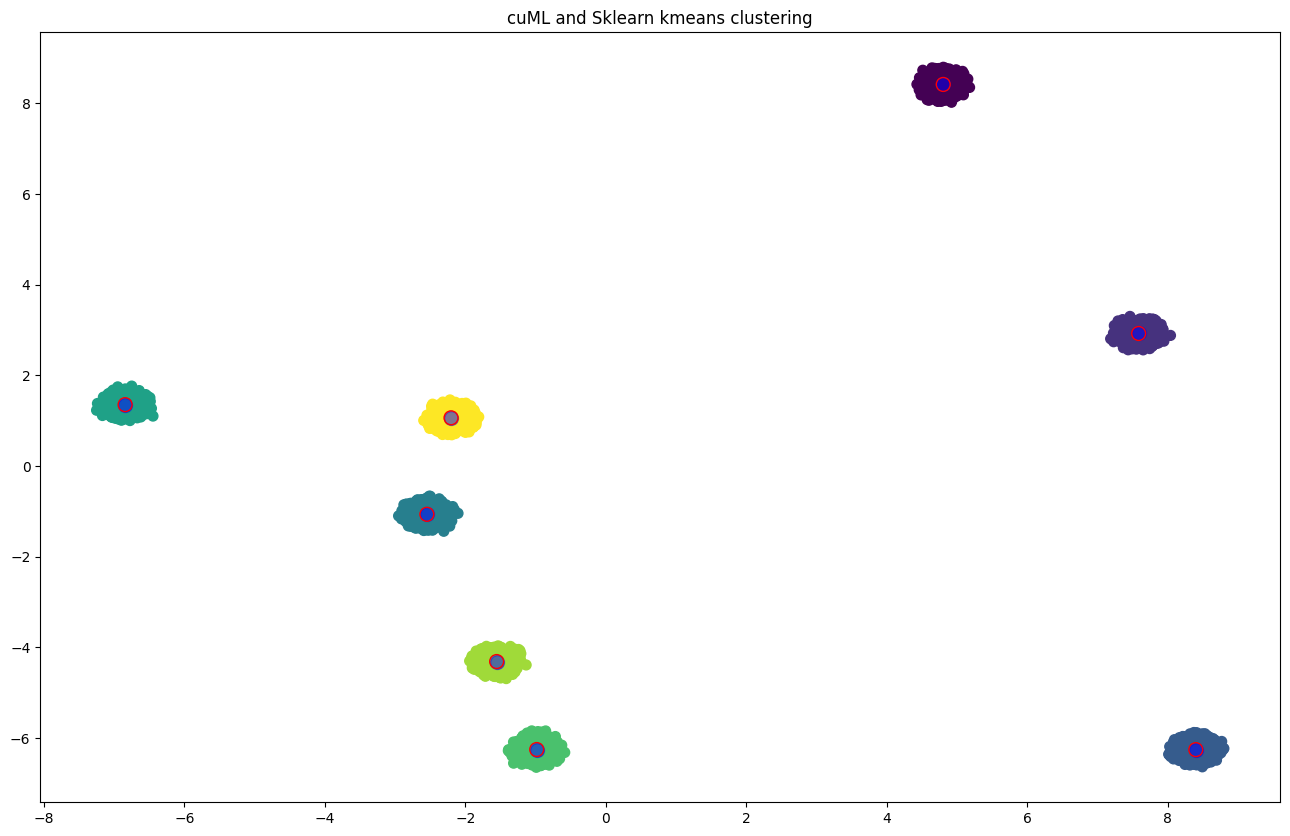

In [23]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data[:, 0], host_data[:,1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans center with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=0.5)

#plot the cuml kmeans center with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[:,0]),
            cupy.asnumpy(centers_cuml[:,1]),
            facecolors = 'none', edgecolors='red', s=100)

plt.title ('cuML and Sklearn kmeans clustering')

plt.show()

In [24]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.get())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)


CPU times: user 15 ms, sys: 1.08 ms, total: 16.1 ms
Wall time: 73.4 ms


In [27]:
# compare

threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print ('Compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

Compare kmeans: cuml vs sklearn labels_ are equal
